# **Báo cáo BTL môn học máy**

*Classify toxic question*

**Họ tên**: Đinh Thị Giang

**MSSV**: 19021258

**Lớp học phần**: INT3405E_20

# **1. Mô tả bài toán**
Quoara là một nền tảng giúp mọi người học hỏi lẫn nhau bằng cách đặt câu hỏi và trả lời để chia sẻ kiến thức. Một thách thức lớn là loại bỏ những câu hỏi thiếu chân thành,những câu hỏi được đặt ra dựa trên những tiền đề sai lầm hoặc có ý định đưa ra một tuyên bố hơn là tìm kiếm những câu trả lời hữu ích

* Mục tiêu: sử dụng tập dữ liệu mà Quora cung cấp để phân loại đâu là những câu hỏi mang ý nghĩa không chân thành, mang nội dung độc hại, gây hiểu lầm
* Input: tập câu hỏi-dữ liệu text
* Output: kết quả cho việc câu hỏi đó có là câu hỏi chân thành hay không(nhãn 0 tương ứng với câu hỏi chân thành, nhãn 1 ứng với câu hỏi không chân thành)


In [ ]:
#import thư viện
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt 
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
import seaborn as sns

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, f1_score,recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC




# **2. Phân tích dữ liệu**
Nhận xét:
dữ liệu được cung cấp bao gồm 2 file chính là train.csv và test.csv trong đó

**file train.csv**
* số dòng: 136122
* số cột: 3 (qid, question_text, target)
    
 Tập dữ liệu không có giá trị null, trùng lặp

**file test.csv**
* số dòng: 375806
* số cột: 2 (qid, question_text)

  Tập dữ liệu không có giá trị null, trùng lặp

**Thông tin về các trường dữ liệu**
* qid: id của câu hỏi
* question_text: các câu hỏi dạng text
* target: phân loại câu hỏi (target = 0 là câu hỏi chân thành, target = 1 là câu hỏi không chân thành)


In [ ]:
#Đọc dữ liệu
train_dir = '../input/quora-insincere-questions-classification/train.csv'
test_dir = '../input/quora-insincere-questions-classification/test.csv'
train_data = pd.read_csv(train_dir)
test_data = pd.read_csv(test_dir)

In [ ]:
#Xem kích thước của các tập dữ liệu
print("Train shape: ", train_data.shape)
print("Test shape: ", test_data.shape)

In [ ]:
#Thông tin về tập dữ liệu train và tập dữ liệu test
train_data.info()
print('\n')
test_data.info() 

In [ ]:
train_data.head()

In [ ]:
test_data.head()

In [ ]:
#Kiểm tra trùng lặp
train_data.duplicated(subset = ["question_text", "qid", "target"]).sum(),test_data.duplicated(subset = ["question_text", "qid"]).sum()


In [ ]:
#Thống kê số câu hỏi chân thành(nhãn 0) và không chân thành(nhãn 1) trong tập train
value_counts = train_data['target'].value_counts()
value_counts_percentage = train_data['target'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
pd.concat([value_counts, value_counts_percentage], axis=1, keys=['target count', 'target distribution'])

In [ ]:
#Biểu diễn số câu chân thành và không chân thành bằng biểu đồ
# Bar chart
plt.subplot(1, 2, 1)

sns.countplot(x="target", data=train_data)
plt.title('Target Count')
plt.subplots_adjust(right=1.5)

# Pie Chart 
plt.subplot(1, 2, 2)
values = [train_data[train_data['target']==0].shape[0], train_data[train_data['target']==1].shape[0]]
labels = ['0-sincere', '1-insincere']

plt.pie(values, autopct='%.2f%%', shadow=True)
plt.title('Target Distribution')
plt.legend(labels, loc="best")
plt.tight_layout()
plt.subplots_adjust(right=1.9)
plt.show()

**Vấn đề: Mất cần bằng dữ liệu**


Tập dữ liệu bị mất cân bằng nghiêm trọng: 
* Số câu hỏi chân thành là 1225312 câu  chiếm  93.81%, 
* Số câu hỏi không chân thành là 80810 câu chiếm 6.19%. 
* Tỷ lệ dữ liệu giữa 2 nhóm là 15:1. 

Tỉ lệ dữ liệu 15:1 sẽ gây ra các vấn đề:
* Ngộ nhận chất lượng mô hình, khi đó thước đo đánh giá mô hình là độ chính xác(accuracy) có thể đạt được rất cao mà không cần tới mô hình, vì vậy ta không chọn độ accuracy làm chỉ số đánh giá mô hình
* Dẫn tới dự báo kém chính xác trên nhóm thiểu số. Bới đa phần kết quả dự báo ra thường thiên về 1 nhóm là nhóm đa số và rất kém trên nhóm thiểu số. Trong khi đó tầm quan trọng của việc dự báo được chính xác một mẫu thuộc nhóm thiểu số lớn hơn so với dự báo thuộc nhóm đa số.  

**Cách giải quyết vấn đề mất cân bằng dữ liệu**

**Thay đổi metric**
Như đã nói, khi hiện tượng mất cân bằng dữ liệu nghiêm trọng xảy ra thì việc sử dụng accuracy làm thước đo đánh giá mô hình là không hiệu quả. Thay vào đó chúng ta có thể dùng các metrics thay thế như: precision, recall, f1_score,... Các chỉ số này sẽ không quá lớn để dẫn tới ngộ nhận độ chính xác, đồng thời chúng tập trung hơn vào việc đánh giá độ chính xác trên nhóm thiểu số

-> Chọn **F1_score** để đánh giá mô hình

Metrics

precision của lớp A: số lượng mẫu đoán đúng là A/số lượng mẫu đoán là A
$$p = \frac{\sum_{i=1}^n \mathbb I(y_i = h(x_i) = A)}{\sum_{i=1}^n \mathbb I(h(x_i) = A)}$$


recall của lớp A: số lượng mẫu đoán đúng là A/số lượng mẫu là A
$$r = \frac{\sum_{i=1}^n \mathbb I(y_i = h(x_i) = A)}{\sum_{i=1}^n \mathbb I(y_i = A)}$$

F1_score của lớp A(trung bình điều hóa giữa precision và recall):
$$\mathrm{F1} = \frac 2 {\frac 1 p + \frac 1 r}$$

-> Sử dụng F1_score để đánh giá chất lượng mô hình

**Cải thiện bằng các phương pháp**: 
Under Sampling, Over Sampling

Trong bài này em dùng Under Sampling để xử lý mất cân bằng dữ liệu





# **3. Xử lý dữ liệu**

Trong tập dữ liệu: có nhiều câu từ trong đó viết sai chính tả, sử dụng các từ viết tắt cùng các ký tự đặc biệt cho nên sẽ gây ảnh hưởng tới kết quả mô hình dự đoán. Việc ta cần làm là loại bỏ nhiễu

1. **Cleaning data**
    * Chuyển về dạng lowercase
    * Sửa các từ sai chính tả
    * Chuẩn hóa các từ viết tắt thành dạng hoàn chỉnh của nó (VD: “2k18” thành “2018”, “wwii” thành “world war 2”.)
    * Xóa các ký tự đặc biệt không phải là chữ/số (VD: “organisation” thành “organization”, “criticise” thành “criticize”.
    * #Loại bỏ stopwords trong câu(đã thử) nhưng không dùng trong version này vì khi loại bỏ stopword thì khả năng phân loại của mô hình giảm xuống
    
    
2. **Finding the root word**: Giảm các dạng vô hướng của mỗi từ thành một cơ sở hoặc gốc chung(để loại bỏ những từ có các digit cuối kiểu s/es/ed mà không làm mất đi nhiều ý nghĩa của câu (VD: words -> word) 
    
    **Lemmatization**: chuyển các từ về dạng nguyên thủy, lemmeatization sẽ xử lý bằng một bộ từ điển nào đó, điều này sẽ đảm bảo rằng các từ như “goes“, “went” và “go” sẽ chắc chắn có kết quả trả về là như nhau
    
3. **Text Vectorization**:

    Vectorization là một kỹ thuật làm cho mã của mình thực thi nhanh chóng. bằng cách sử dụng triển khai vector hóa trong một thuật toán tối ưu hóa, điều này có thể làm cho quá trình tính toán nhanh hơn nhiều
    * Count Vectorizer: chia câu hỏi thành các từ, chuyển nó thành một vector trên cơ sở tần suất, được sử dụng để chuyển đổi một bộ sưu tập các tài liệu văn bản thành một vectơ có số lượng thuật ngữ / mã thông báo. Nó cũng cho phép xử lý trước dữ liệu văn bản trước khi tạo biểu diễn vectơ. Chức năng này làm cho nó trở thành một mô-đun biểu diễn tính năng rất linh hoạt cho văn bản.
    
    Nhược điểm:

        * Không xác định được mức độ quan trọng giữa các từ.
        * Không xác định mối quan hệ giữa các từ với nhau
        * Chỉ đánh giá những từ xuất hiện nhiều trong kho văn bản mới có ý nghĩa về mặt thống kê.

    * TF_IDF(Term Frequency-Inverde Document Frequency): là 1 kĩ thuật sử dụng trong khai phá dữ liệu văn bản, giúp đánh trọng số cho mỗi từ trong văn bản, trong đó TF là tần số xuất hiện của từ trong văn bản và idf là tần số nghịch giúp làm giảm giá trị của những từ phổ biến.Trọng số này được sử dụng để đánh giá tầm quan trọng của một từ trong một văn bản. Giá trị cao thể hiện độ quan trọng cao và nó phụ thuộc vào số lần từ xuất hiện trong văn bản nhưng bù lại bởi tần suất của từ đó trong tập dữ liệu. 
 
    
4. **Splitting**: chia tập train thành 2 tập theo tỉ lệ 80% để huấn luyện, 20% để xác thực



In [ ]:
# 1.cleaning data

contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because","could've": "could have", "couldn't": "could not", "didn't": "did not","doesn't": "does not","don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not","he'd": "he would","he'll": "he will","he's": "he is", "how'd": "how did","how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would","I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am","I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would","it'd've": "it would have", "it'll": "it will","it'll've": "it will have","it's": "it is","let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not","oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have","she'd": "she would", "she'd've": "she would have", "she'll": "she will","she'll've": "she will have", "she's": "she is", "should've": "should have","shouldn't": "should not","shouldn't've": "should not have", "so've": "so have","so's": "so as","this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is","there'd": "there would","there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have","wasn't": "was not","we'd": "we would","we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are", "we've": "we have", "weren't": "were not","what'll": "what will","what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have","when's": "when is", "when've": "when have", "where'd": "where did","where's": "where is", "where've": "where have", "who'll": "who will","who'll've": "who will have", "who's": "who is","who've": "who have", "why's": "why is", "why've": "why have","will've": "will have","won't": "will not", "won't've": "will not have","would've": "would have", "wouldn't": "would not","wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have","you're": "you are", "you've": "you have"}                    
          
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling','counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor','organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do','whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many','whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation','mastrubate': 'masturbate', "mastrubating": 'masturbating','pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data','2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp','demonitisation': 'demonetization','demonitization': 'demonetization', 'demonetisation': 'demonetization','electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin','lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency','simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized','iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime','cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp','undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp','reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone','dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu','openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp','empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money','fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation','trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath','bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized','brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language','splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu','weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency'}


# Chỉnh từ viết tắt thành hoàn chỉnh
def replace_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([contraction_dict[t] if t in contraction_dict else t for t in text.split(" ")])
    return text
            
# Chỉnh từ bị sai chính tả   
def replace_mispell(x):
    words = x.split()
    for i in range(0, len(words)):
        if mispell_dict.get(words[i]) is not None:
            words[i] = mispell_dict.get(words[i])
        elif mispell_dict.get(words[i].lower()) is not None:
            words[i] = mispell_dict.get(words[i].lower())
    words = " ".join(words)
    return words

#Xóa các từ ở trong stopwords
# def remove_stopwords(text):
#     text = [word for word in text.split() if word not in STOPWORDS]
#     text = ' '.join(text)
#     return text

In [ ]:
# 2. Lemmatization-chuyển từ về dạng nguyên thủy-"cần chỉnh lại"
#VD: rocks: rock, corpora: corpus, better: good

lemmatizer = WordNetLemmatizer()
def lemma_text(text):
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text] 
    text = " ".join(text)
    return text

In [ ]:
#hàm chung để xử lý dữ liệu
def clean_text(x):
    x = x.lower() #chuyển thành chữ in thường
    x = replace_mispell(x)
    #x = remove_stopwords(x)
    x = replace_contractions(x)
    #x = lemma_text(x)
    x = re.sub(r'[^a-zA-Z0-9]', ' ', x) #Loại bỏ các ký tự không phải là chữ, số
    return x

In [ ]:
#tiền xử lý dữ liệu tập train
train_data["processed_text"] = train_data["question_text"].apply(lambda x: clean_text(x))
train_data.head()

In [ ]:
#tiền xử lý dữ liệu tập test
test_data["processed_text"] = test_data["question_text"].apply(lambda x: clean_text(x))
test_data.head()

In [ ]:
#ngram_range=(1,3) để tạo được các cụm từ gồm 1-3 từ trong bộ dữ liệu
#3.1 Count Vectorizer
c_vectorizer = CountVectorizer(ngram_range=(1,3))
def count_vec(xtr, xte):
    cv_train = c_vectorizer.fit_transform(xtr)
    cv_test = c_vectorizer.transform(xte)
    return cv_train, cv_test

#3.2 TF-IDF
tf_vectorizer = TfidfVectorizer(ngram_range=(1,3))
def tfidf_vec(xtr, xte):
    tf_train =  tf_vectorizer.fit_transform(xtr) 
    tf_test = tf_vectorizer.transform(xte)
    return tf_train, tf_test


In [ ]:
#4. chia dữ liệu thành 2 tập theo tỉ lệ 4:1
def split_data():
    X = train_data['processed_text']
    y = train_data['target']
    xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=123)
    return xtr, xte, ytr, yte

# **4. Xây dựng Model**


In [ ]:
def get_eval(yte, ypred):
    recall = recall_score(yte, ypred)
    f1 = f1_score(yte, ypred)
    print('Recall: ', recall)
    print('F1 score :', f1, '\n')
    print(classification_report(yte, ypred))
    return recall, f1

In [ ]:
xtr, xte, ytr, yte = split_data()

cv_train, cv_test = count_vec(xtr, xte)
#tf_train, tf_test = tfidf_vec(xtr, xte)

**1. Logistic Regression** 

Sử dụng Count Vectorizer do dùng TFIDF kết quả mô hình thấp hơn

Hồi quy logistic là một phương pháp phân tích thống kê được sử dụng để dự đoán giá trị dữ liệu dựa trên các quan sát trước đó, việc sử dụng Logistic cho bài toán phân loại nhị phân đối với bài này là khá phù hợp

tham khảo: [https://excessive-source-1c9.notion.site/16-09-2021-H-i-quy-Logistics-cdcc911147e5458ba9203b58e6bd0099](http://)


In [ ]:
lrg = LogisticRegression(solver='liblinear', class_weight="balanced")
lrg.fit(cv_train,ytr)
ypred1=lrg.predict(cv_test)
lrg_recall, lrg_f1 = get_eval(yte, ypred1)


**2. Bernoulli Naive Bayes**

Naive Bayes là một thuật toán phân lớp được mô hình hóa dựa trên định lý Bayes trong xác suất thống kê-khi cho một đầu vào, nó dự đoán xác suất đầu vào được phân loại cho tất cả các lớp

**Định lý Bayes**
$$P(B|A) = \frac{P(A|B)P(B)}{P(A)}$$
Trong đó:
* P(A|B): likelihood
* P(B|A): hậu nghiệm
* P(B): tiên nghiệm

Trong mô hình Naive Bayes, có hai giả thiết được đặt ra:
* Các đặc trưng đưa vào mô hình độc lập với nhau. Tức là dự thay đổi giá trị của một đặc trưng không ảnh hưởng đến các đặc trưng còn lại
* Các đặc trưng đưa vào mô hình có ảnh hưởng ngang nhau đối vơi đầu ra mục tiêu

Vì đặc trưng đầu vào chỉ nhận giá trị nhị phân 0 hoặc 1(phân bố Bernoulli) nên dùng Bernoulli Naive Bayes

* Ưu điểm của Bernoulli Naive Bayes là dễ sử dụng và nhanh khi cần dự đoán nhãn của dữ liệu test.Khi giả định rằng các đặc trưng của dữ liệu là độc lập với nhau thì nó chạy tốt hơn các thuật toán khác như Logistic regression khi có ít dữ liệu đào tạo.
* Nhược điểm là độ chính xác so với các thuật toán khác không được cao



In [ ]:
bnb = BernoulliNB(alpha=0.01)
bnb.fit(cv_train,ytr)
ypred2 = bnb.predict(cv_test)
bnb_recall, bnb_f1 = get_eval(yte, ypred2)

**3. XGBoost**

được sử dụng để giải quyết tất cả các vấn đề từ hồi quy, phân loại,..

tham khảo: [https://excessive-source-1c9.notion.site/11-11-2021-Ph-ng-ph-p-Boosting-714c287d19494eb88e8b13cc9d96650e#959b0236cf234c2b804e7fe97749ddb1](http://)

In [ ]:
xgb = XGBClassifier(use_label_encoder =False)
xgb.fit(cv_train,ytr)
ypred3 = xgb.predict(cv_test)
xgb_recall, xgb_f1 = get_eval(yte, ypred3)


**4. SVM**

Support Vector Machine(SMV) dùng để phân chia dữ liệu thành các nhóm riêng biệt
LinearSVC giúp ta tìm được đường phân chia giữa 2 lớp sao cho margin là lớn nhất. Việc margin rộng hơn sẽ mang lại hiệu ứng phân lớp tốt hơn vì sự phân chia giữa 2 class là rạch ròi hơn

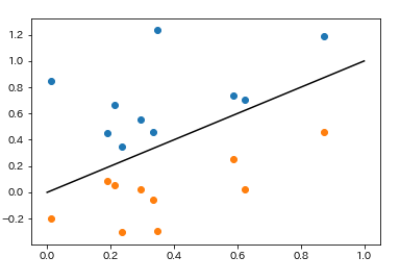

Tham khảo[https://excessive-source-1c9.notion.site/27-11-2021-M-y-vector-h-tr-SVM-afd3d10f1adf4936b85a2830aa4a1aaf](http://)

In [ ]:
svm = LinearSVC(max_iter = 4000)
svm.fit(cv_train,ytr)
ypred4 = svm.predict(cv_test)
svm_ecall, svm_f1 = get_eval(yte, ypred4)


In [ ]:
# So sánh các mô hình

df_eval=pd.DataFrame({'Model':["Logistic Regression", "Bernoulli Naive Bayes", "XGBoost", "SVM"],
                      'Recall':[lrg_recall, bnb_recall, xgb_recall,svm_ecall],'F1_score':[lrg_f1,bnb_f1,xgb_f1, svm_f1]})
df_eval

In [ ]:
objects = ("Logistic Regression", "Bernoulli Naive Bayes", "XGBoost", "SVM")
ypos = np.arange(len(objects))
per = [lrg_f1, bnb_f1, xgb_f1, svm_f1]
plt.figure(figsize=(9, 9))
plt.bar(ypos, per, align='center', alpha=0.6)

plt.xticks(ypos, objects)

plt.ylabel('F1_score')
plt.title('Classifier')

plt.show()

Nhận xét: Kết quả thu được từ 3 mô hình cho thấy mô hình Logistic Regression là cao và ổn định nhất, XGBoost có thể thấy là không hiệu quả trong bài toán này


# **5. Under Sampling**

Từ kết quả của 4 mô hình trên, chọn mô hình Logistic Regression để under sampling

Under sampling là việc ta giảm số lượng các mẫu của nhóm đa số để nó trở lên cân bằng với dữ liệu của nhóm thiểu số. Ưu điểm của under sampling là làm cân bằng dữ mẫu một cách nhanh chóng, dễ dàng tiến hành thực hiện mà không cần đến thuật toán giả lập mẫu. Tuy nhiên nhược điểm của nó là kích thước mẫu sẽ giảm đáng kể


**Chuẩn bị dữ liệu**

In [ ]:
#Lấy câu chân thành từ tập câu không chân thành và ngược lại
insincere = train_data[train_data['target']==0]
sincere = train_data[train_data['target']==1]
#Lấy số lượng câu hỏi không chân thành = số lượng câu hỏi chân thành
insincere = insincere[:len(sincere)]
len(insincere), len(sincere)

In [ ]:
#Ghép 2 tập
qtrain = pd.concat([insincere, sincere])
val_count = qtrain['target'].value_counts()
val_count

In [ ]:
x_tr, x_te, y_tr, y_te = train_test_split(qtrain['processed_text'], qtrain['target'], test_size=0.2, random_state=123)
tf_train, tf_test = tfidf_vec(x_tr, x_te)

**Huấn luyện**

In [ ]:
lr = LogisticRegression(solver='liblinear', class_weight="balanced")
lr.fit(tf_train,y_tr)
ypred=lr.predict(tf_test)
lr_recall, lr_f1 = get_eval(y_te, ypred)

Nhận xét: Áp dụng under sampling cải thiện tốt khả năng dự đoán trên tập validation, điểm số F1_score trên tập validation tăng chủ yếu do số lượng mẫu dùng để đánh giá mô hình trên tập này đã giảm rất nhiều so với ban đầu.


# **6. Submit**


In [ ]:
Y = test_data['processed_text']

x = c_vectorizer.transform(Y)
#pred_te = lrg.predict(x)
test_data['prediction'] = lrg.predict(x)
test_data.head()

In [ ]:
result = test_data[['qid', 'prediction']]
result.to_csv('submission.csv', index=False)
result.head()

Đây là điểm cao nhất em đạt được bằng mô hình Logistic Regression


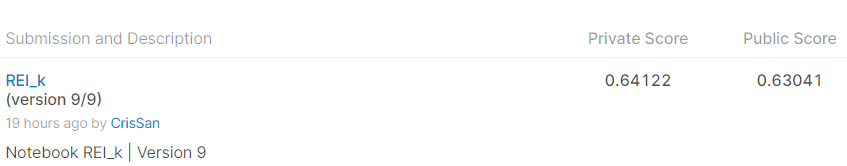